# Redes GANS
As redes GANs (Generative Adversarial Networks) são um tipo de rede neural que é capaz de gerar novas amostras de dados que são semelhantes a um conjunto de dados de treinamento. A ideia é a rede GAN ser composta por duas redes neurais, uma chamada de gerador e outra chamada de discriminador. O gerador é responsável por gerar novas amostras de dados, enquanto o discriminador é responsável por distinguir entre amostras reais e falsas. O gerador e o discriminador são treinados em conjunto, de modo que o gerador aprende a gerar amostras de dados que são cada vez mais semelhantes às amostras reais, enquanto o discriminador aprende a distinguir entre amostras reais e falsas.

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import os

In [88]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')

print(f"Using device: {DEVICE}")

Using device: mps


# Carregando dados

In [94]:
# Transformação e carregamento do dataset MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)

## Criando Modelos

In [95]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 7*7*256, bias=False),
            nn.BatchNorm1d(7*7*256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (256, 7, 7)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(256*4*4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [96]:
generator = Generator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

## Treianando Modelos

In [99]:
def train_GAN(generator, discriminator, criterion, optimizer_G, optimizer_D, dataloader, num_epochs=50):
    fixed_noise = torch.randn(16, 100, device=DEVICE)

    for epoch in range(num_epochs):
        for i, (images, _) in enumerate(dataloader):
            batch_size = images.size(0)
            images = images.to(DEVICE)

            real_labels = torch.ones(batch_size, 1).to(DEVICE)
            fake_labels = torch.zeros(batch_size, 1).to(DEVICE)

            # Treina o discriminador
            outputs = discriminator(images)
            d_loss_real = criterion(outputs, real_labels)
            real_score = outputs

            noise = torch.randn(batch_size, 100, device=DEVICE)
            fake_images = generator(noise)
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(outputs, fake_labels)
            fake_score = outputs

            d_loss = d_loss_real + d_loss_fake
            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

            # Treina o gerador
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)

            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()

            if (i + 1) % 50 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')

        # Salva as imagens geradas
        with torch.no_grad():
            fake_images = generator(fixed_noise)
            plt.figure(figsize=(4, 4))
            plt.title(f'Epoch {epoch+1}')
            for i in range(16):
                plt.subplot(4, 4, i+1)
                plt.imshow(fake_images[i].cpu().numpy().transpose(1, 2, 0).squeeze(), cmap='gray')
                plt.axis('off')
            plt.show()
                

Epoch [1/15], Step [50/235], D Loss: 0.0043, G Loss: 6.3817
Epoch [1/15], Step [100/235], D Loss: 0.0035, G Loss: 9.5982
Epoch [1/15], Step [150/235], D Loss: 0.0022, G Loss: 7.5107
Epoch [1/15], Step [200/235], D Loss: 0.0009, G Loss: 8.2257


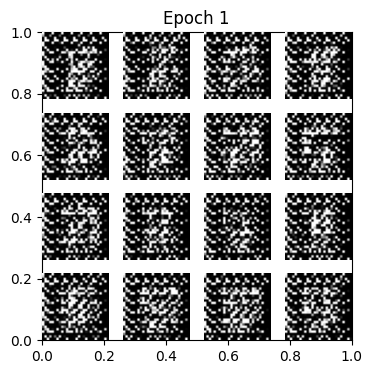

Epoch [2/15], Step [50/235], D Loss: 0.0005, G Loss: 8.9578
Epoch [2/15], Step [100/235], D Loss: 0.0003, G Loss: 9.2702
Epoch [2/15], Step [150/235], D Loss: 0.0006, G Loss: 8.3780
Epoch [2/15], Step [200/235], D Loss: 0.0004, G Loss: 9.0041


<Figure size 640x480 with 0 Axes>

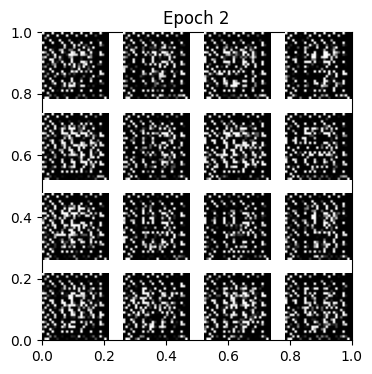

Epoch [3/15], Step [50/235], D Loss: 0.0002, G Loss: 9.7073
Epoch [3/15], Step [100/235], D Loss: 0.0002, G Loss: 9.8702
Epoch [3/15], Step [150/235], D Loss: 0.0001, G Loss: 9.9738
Epoch [3/15], Step [200/235], D Loss: 0.0001, G Loss: 10.0064


<Figure size 640x480 with 0 Axes>

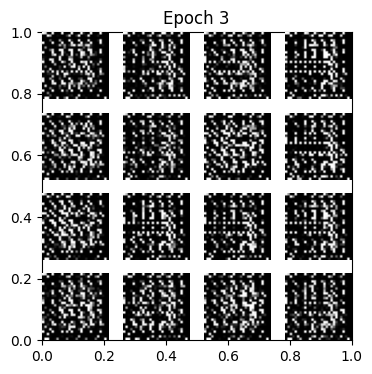

Epoch [4/15], Step [50/235], D Loss: 0.0001, G Loss: 10.3000
Epoch [4/15], Step [100/235], D Loss: 0.0001, G Loss: 10.3978
Epoch [4/15], Step [150/235], D Loss: 0.0001, G Loss: 10.0701
Epoch [4/15], Step [200/235], D Loss: 0.0001, G Loss: 10.3715


<Figure size 640x480 with 0 Axes>

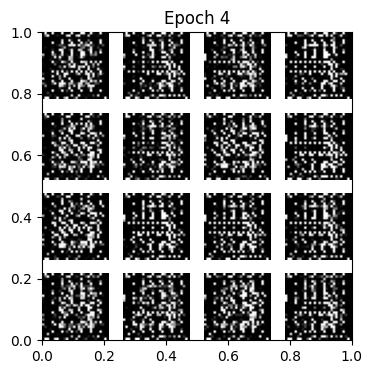

Epoch [5/15], Step [50/235], D Loss: 0.0001, G Loss: 10.7263
Epoch [5/15], Step [100/235], D Loss: 0.0001, G Loss: 10.9109
Epoch [5/15], Step [150/235], D Loss: 0.0000, G Loss: 10.9913
Epoch [5/15], Step [200/235], D Loss: 0.0001, G Loss: 11.1151


<Figure size 640x480 with 0 Axes>

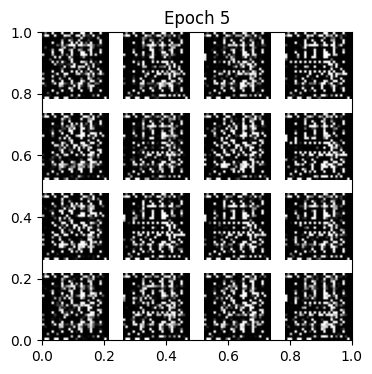

Epoch [6/15], Step [50/235], D Loss: 0.0000, G Loss: 11.3253
Epoch [6/15], Step [100/235], D Loss: 0.0000, G Loss: 11.3449
Epoch [6/15], Step [150/235], D Loss: 0.0000, G Loss: 11.4315
Epoch [6/15], Step [200/235], D Loss: 0.0000, G Loss: 11.4851


<Figure size 640x480 with 0 Axes>

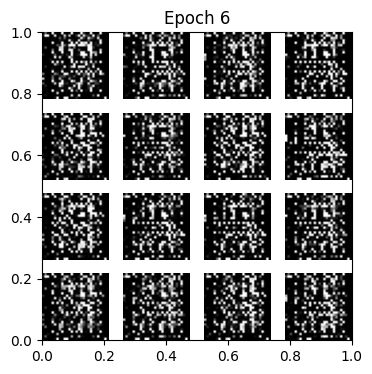

Epoch [7/15], Step [50/235], D Loss: 0.0000, G Loss: 11.6411
Epoch [7/15], Step [100/235], D Loss: 0.0001, G Loss: 10.3451
Epoch [7/15], Step [150/235], D Loss: 0.0001, G Loss: 10.7414
Epoch [7/15], Step [200/235], D Loss: 0.0000, G Loss: 10.9885


<Figure size 640x480 with 0 Axes>

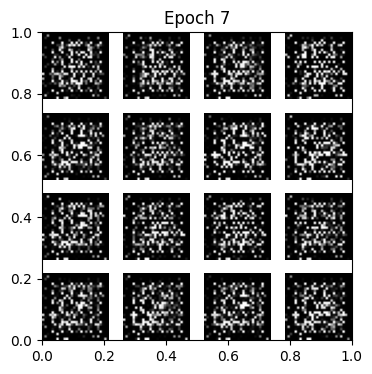

Epoch [8/15], Step [50/235], D Loss: 0.0000, G Loss: 11.2460
Epoch [8/15], Step [100/235], D Loss: 0.0000, G Loss: 11.3761
Epoch [8/15], Step [150/235], D Loss: 0.0000, G Loss: 11.4421
Epoch [8/15], Step [200/235], D Loss: 0.0000, G Loss: 11.5254


<Figure size 640x480 with 0 Axes>

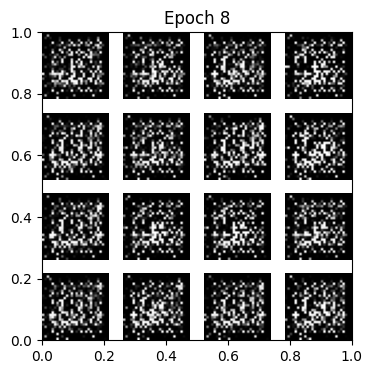

Epoch [9/15], Step [50/235], D Loss: 0.0000, G Loss: 11.6441
Epoch [9/15], Step [100/235], D Loss: 0.0000, G Loss: 11.7833
Epoch [9/15], Step [150/235], D Loss: 0.0000, G Loss: 11.9124
Epoch [9/15], Step [200/235], D Loss: 0.0000, G Loss: 11.9673


<Figure size 640x480 with 0 Axes>

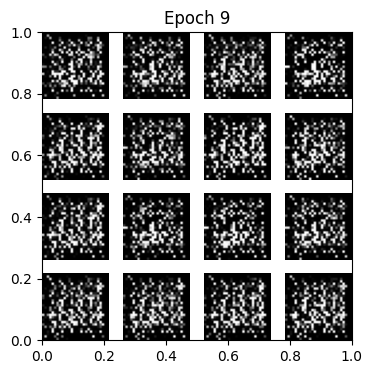

Epoch [10/15], Step [50/235], D Loss: 0.0000, G Loss: 12.0796
Epoch [10/15], Step [100/235], D Loss: 0.0000, G Loss: 12.1310
Epoch [10/15], Step [150/235], D Loss: 0.0000, G Loss: 12.0989
Epoch [10/15], Step [200/235], D Loss: 0.0000, G Loss: 12.1211


<Figure size 640x480 with 0 Axes>

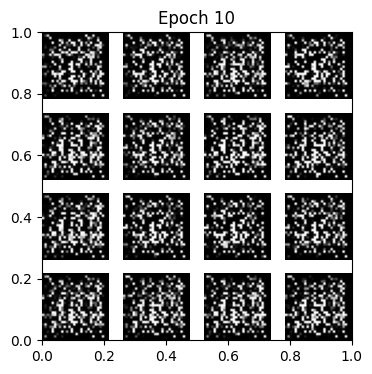

Epoch [11/15], Step [50/235], D Loss: 0.0000, G Loss: 12.2219
Epoch [11/15], Step [100/235], D Loss: 0.0000, G Loss: 12.3081
Epoch [11/15], Step [150/235], D Loss: 0.0000, G Loss: 12.4048
Epoch [11/15], Step [200/235], D Loss: 0.0000, G Loss: 12.3867


<Figure size 640x480 with 0 Axes>

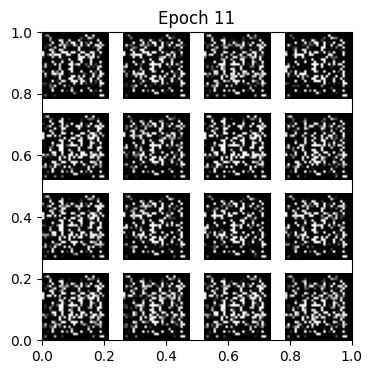

Epoch [12/15], Step [50/235], D Loss: 0.0000, G Loss: 12.4065
Epoch [12/15], Step [100/235], D Loss: 0.0000, G Loss: 12.4627
Epoch [12/15], Step [150/235], D Loss: 0.0000, G Loss: 12.4594
Epoch [12/15], Step [200/235], D Loss: 0.0000, G Loss: 12.4918


<Figure size 640x480 with 0 Axes>

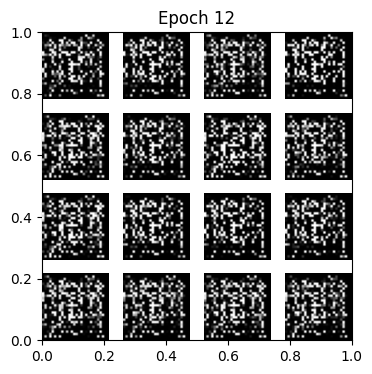

Epoch [13/15], Step [50/235], D Loss: 0.0000, G Loss: 12.5895
Epoch [13/15], Step [100/235], D Loss: 0.0000, G Loss: 12.7126
Epoch [13/15], Step [150/235], D Loss: 0.0000, G Loss: 12.6941
Epoch [13/15], Step [200/235], D Loss: 0.0000, G Loss: 12.7652


<Figure size 640x480 with 0 Axes>

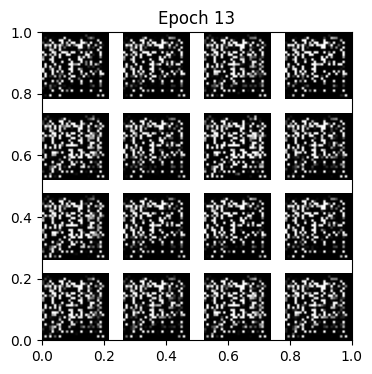

Epoch [14/15], Step [50/235], D Loss: 0.0000, G Loss: 12.8304
Epoch [14/15], Step [100/235], D Loss: 0.0000, G Loss: 12.9358
Epoch [14/15], Step [150/235], D Loss: 0.0000, G Loss: 13.0197
Epoch [14/15], Step [200/235], D Loss: 0.0000, G Loss: 13.0658


<Figure size 640x480 with 0 Axes>

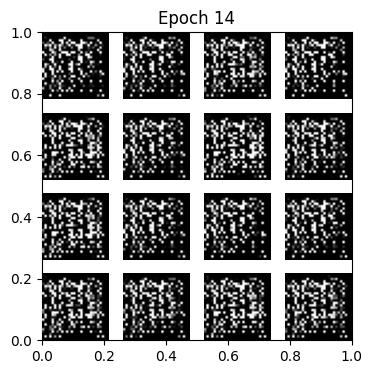

Epoch [15/15], Step [50/235], D Loss: 0.0000, G Loss: 13.2311
Epoch [15/15], Step [100/235], D Loss: 0.0000, G Loss: 13.2873
Epoch [15/15], Step [150/235], D Loss: 0.0000, G Loss: 13.3479
Epoch [15/15], Step [200/235], D Loss: 0.0000, G Loss: 13.4167


<Figure size 640x480 with 0 Axes>

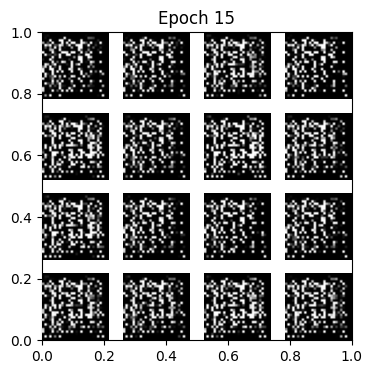

<Figure size 640x480 with 0 Axes>

In [100]:
train_GAN(generator, discriminator, criterion, optimizer_G, optimizer_D, train_loader, num_epochs=15)

Epoch [1/15], Step [50/235], D Loss: 0.0000, G Loss: 13.4547
Epoch [1/15], Step [100/235], D Loss: 0.0000, G Loss: 13.4072
Epoch [1/15], Step [150/235], D Loss: 0.0000, G Loss: 13.4315
Epoch [1/15], Step [200/235], D Loss: 0.0000, G Loss: 13.4292


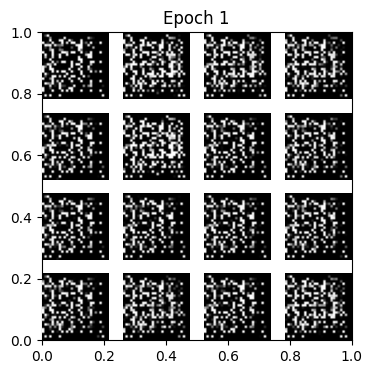

Epoch [2/15], Step [50/235], D Loss: 0.0000, G Loss: 13.5552
Epoch [2/15], Step [100/235], D Loss: 0.0000, G Loss: 13.6165
Epoch [2/15], Step [150/235], D Loss: 0.0000, G Loss: 13.6559
Epoch [2/15], Step [200/235], D Loss: 0.0000, G Loss: 13.7517


<Figure size 640x480 with 0 Axes>

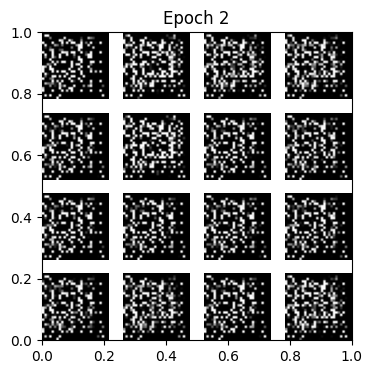

Epoch [3/15], Step [50/235], D Loss: 0.0000, G Loss: 13.8356
Epoch [3/15], Step [100/235], D Loss: 0.0000, G Loss: 13.8778
Epoch [3/15], Step [150/235], D Loss: 0.0000, G Loss: 13.9032
Epoch [3/15], Step [200/235], D Loss: 0.0000, G Loss: 13.9424


<Figure size 640x480 with 0 Axes>

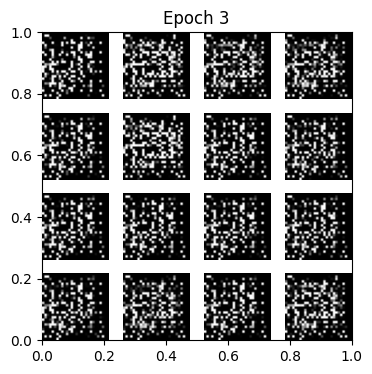

Epoch [4/15], Step [50/235], D Loss: 0.0000, G Loss: 13.7139
Epoch [4/15], Step [100/235], D Loss: 0.0000, G Loss: 13.6756
Epoch [4/15], Step [150/235], D Loss: 0.0000, G Loss: 13.7232
Epoch [4/15], Step [200/235], D Loss: 0.0000, G Loss: 13.7009


<Figure size 640x480 with 0 Axes>

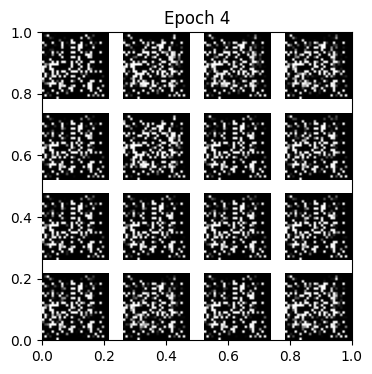

Epoch [5/15], Step [50/235], D Loss: 0.0000, G Loss: 13.7642
Epoch [5/15], Step [100/235], D Loss: 0.0000, G Loss: 12.2035
Epoch [5/15], Step [150/235], D Loss: 0.0000, G Loss: 12.5477
Epoch [5/15], Step [200/235], D Loss: 0.0000, G Loss: 12.9565


<Figure size 640x480 with 0 Axes>

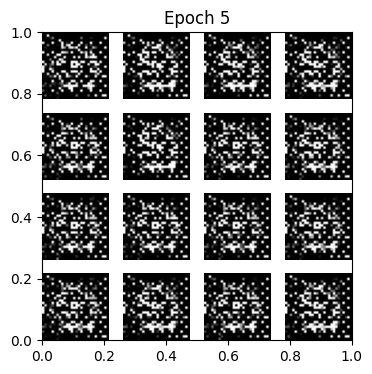

Epoch [6/15], Step [50/235], D Loss: 0.0000, G Loss: 13.2836
Epoch [6/15], Step [100/235], D Loss: 0.0000, G Loss: 13.4370
Epoch [6/15], Step [150/235], D Loss: 0.0000, G Loss: 13.5016
Epoch [6/15], Step [200/235], D Loss: 0.0000, G Loss: 13.5115


<Figure size 640x480 with 0 Axes>

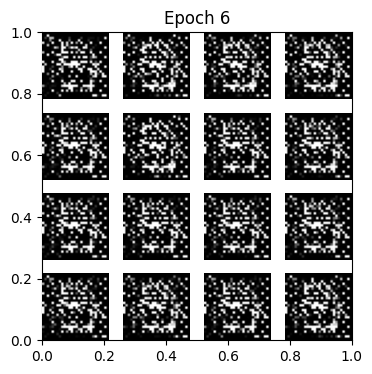

Epoch [7/15], Step [50/235], D Loss: 0.0000, G Loss: 13.5159
Epoch [7/15], Step [100/235], D Loss: 0.0000, G Loss: 13.3587
Epoch [7/15], Step [150/235], D Loss: 0.0000, G Loss: 13.2903
Epoch [7/15], Step [200/235], D Loss: 0.0000, G Loss: 13.3630


<Figure size 640x480 with 0 Axes>

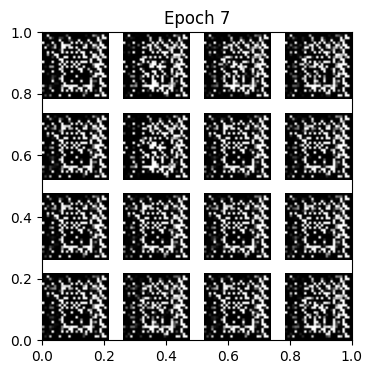

Epoch [8/15], Step [50/235], D Loss: 0.0000, G Loss: 13.4789
Epoch [8/15], Step [100/235], D Loss: 0.0000, G Loss: 13.5552
Epoch [8/15], Step [150/235], D Loss: 0.0000, G Loss: 13.5871
Epoch [8/15], Step [200/235], D Loss: 0.0000, G Loss: 13.7611


<Figure size 640x480 with 0 Axes>

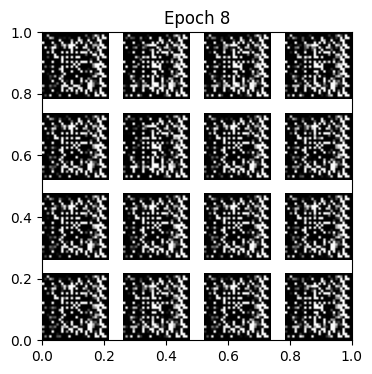

Epoch [9/15], Step [50/235], D Loss: 0.0000, G Loss: 13.9974
Epoch [9/15], Step [100/235], D Loss: 0.0000, G Loss: 14.1177
Epoch [9/15], Step [150/235], D Loss: 0.0000, G Loss: 14.1587
Epoch [9/15], Step [200/235], D Loss: 0.0000, G Loss: 14.2408


<Figure size 640x480 with 0 Axes>

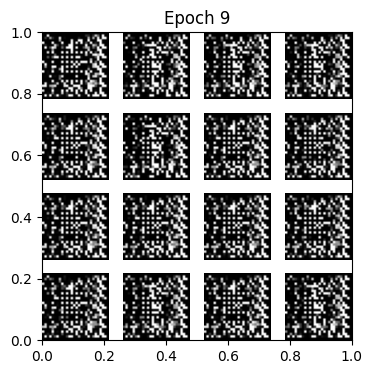

Epoch [10/15], Step [50/235], D Loss: 1.4699, G Loss: 0.2158
Epoch [10/15], Step [100/235], D Loss: 1.9865, G Loss: 2.8094
Epoch [10/15], Step [150/235], D Loss: 0.6735, G Loss: 1.0435
Epoch [10/15], Step [200/235], D Loss: 0.5007, G Loss: 2.7434


<Figure size 640x480 with 0 Axes>

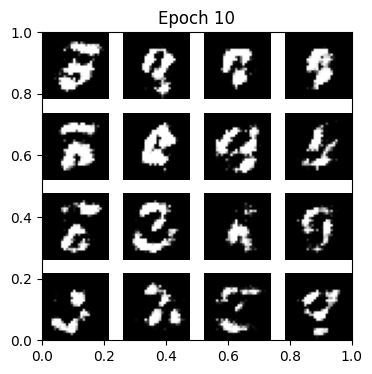

Epoch [11/15], Step [50/235], D Loss: 0.6927, G Loss: 1.6480
Epoch [11/15], Step [100/235], D Loss: 0.7336, G Loss: 2.9984
Epoch [11/15], Step [150/235], D Loss: 0.9697, G Loss: 1.2855
Epoch [11/15], Step [200/235], D Loss: 0.4724, G Loss: 1.8253


<Figure size 640x480 with 0 Axes>

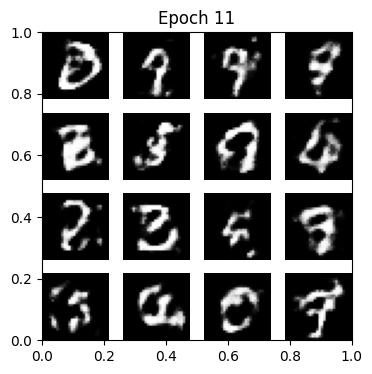

Epoch [12/15], Step [50/235], D Loss: 0.6362, G Loss: 1.9243
Epoch [12/15], Step [100/235], D Loss: 0.7004, G Loss: 1.6892
Epoch [12/15], Step [150/235], D Loss: 0.9632, G Loss: 3.1978
Epoch [12/15], Step [200/235], D Loss: 0.6809, G Loss: 2.2538


<Figure size 640x480 with 0 Axes>

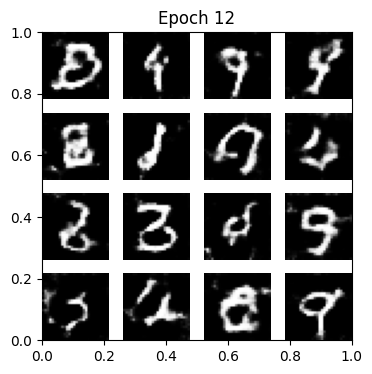

Epoch [13/15], Step [50/235], D Loss: 0.5849, G Loss: 1.9124
Epoch [13/15], Step [100/235], D Loss: 0.6881, G Loss: 1.1229
Epoch [13/15], Step [150/235], D Loss: 0.5831, G Loss: 1.6515
Epoch [13/15], Step [200/235], D Loss: 0.5609, G Loss: 1.9548


<Figure size 640x480 with 0 Axes>

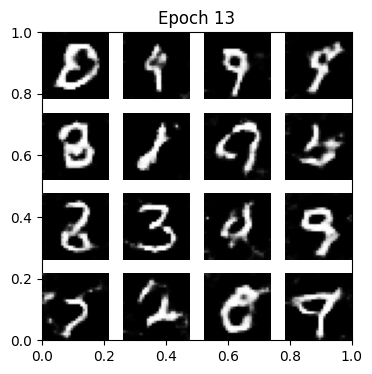

Epoch [14/15], Step [50/235], D Loss: 0.5386, G Loss: 1.8840
Epoch [14/15], Step [100/235], D Loss: 0.9822, G Loss: 3.5901
Epoch [14/15], Step [150/235], D Loss: 0.4017, G Loss: 1.9375
Epoch [14/15], Step [200/235], D Loss: 0.4583, G Loss: 1.8141


<Figure size 640x480 with 0 Axes>

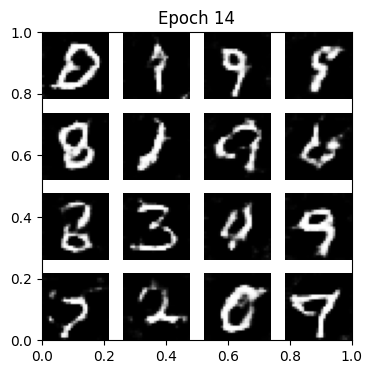

Epoch [15/15], Step [50/235], D Loss: 0.4045, G Loss: 1.9913
Epoch [15/15], Step [100/235], D Loss: 0.3549, G Loss: 2.4421
Epoch [15/15], Step [150/235], D Loss: 0.3713, G Loss: 1.9394
Epoch [15/15], Step [200/235], D Loss: 0.3381, G Loss: 2.6269


<Figure size 640x480 with 0 Axes>

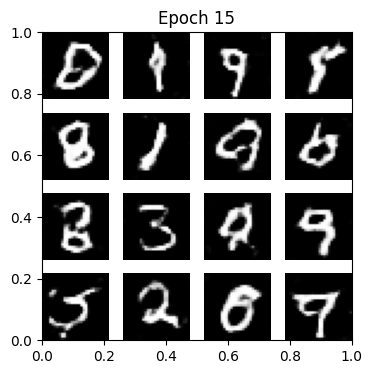

<Figure size 640x480 with 0 Axes>

In [101]:
train_GAN(generator, discriminator, criterion, optimizer_G, optimizer_D, train_loader, num_epochs=15)